In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import scipy.spatial.distance 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from collections import defaultdict
from math import sqrt
import matplotlib.mlab as mlab      
import matplotlib.pylab as pl

path_train='/Users/meidou/DeskTop/ml-100k/ua.base'
r_cols = ['user_id', 'item_id', 'rating','time']
ubase= pd.read_csv(path_train,sep='\t',names=r_cols);
ubase.drop(['time'],inplace=True,axis=1)
ubase1=pd.pivot_table(ubase,index='user_id',columns='item_id',values='rating').fillna(0)
m=ubase1.shape[0] #users
n=ubase1.shape[1] #items
#print(m,n)
#print(ubase1.head())
items=list(set(ubase['item_id']))#all the movies in ubase
#print(items)
users=set(ubase['user_id'])#all the users in ubase

path_test='/Users/meidou/DeskTop/ml-100k/ua.test'
r_cols = ['user_id', 'item_id', 'rating','time']
utest= pd.read_csv(path_test,sep='\t',names=r_cols);
utest.drop(['time'],inplace=True,axis=1)
utest1=pd.pivot_table(utest,index='user_id',columns='item_id',values='rating').fillna(0)
m_t=utest1.shape[0] # users
n_t=utest1.shape[1] # items
test_items=list(set(utest['item_id'])) #all the movies in utest
#users_test=set(utest['user_id'])#all the users in utest


#both_users=list(users.intersection(users_test)) # users in both ubase and utest


def similar_users(u,ratings,k,metric):
    similarities = []
    u_neighbours = []
    
    nbrs = NearestNeighbors(metric=metric, n_neighbors=k,algorithm='auto').fit(ratings)
    loc = ratings.index.get_loc(u)
    similarities, u_neighbours = nbrs.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors=k+1)
    similarities = 1 - similarities.flatten()
    u_neighbours=u_neighbours[0]
    #print(similarities,u_neighbours)
    return similarities, u_neighbours

def similar_items(v,ratings,k,metric):
    similarities = []
    v_neighbours = []
    ratings=ratings.T
    
    nbrs = NearestNeighbors(metric=metric, n_neighbors=k,algorithm='auto').fit(ratings)
    loc = ratings.index.get_loc(v)
    similarities, v_neighbours = nbrs.kneighbors(ratings.iloc[loc, :].values.reshape(1, -1), n_neighbors=k+1)
    similarities = 1 - similarities.flatten()
    v_neighbours=v_neighbours[0]
    #print(similarities,v_neighbours)
    return similarities, v_neighbours

def predict_users(k,u,ratings,items):
    metric='correlation'
    
    #get the k neighbours ui
    similarities, u_neighbours=similar_users(u,ratings,k,metric)
    #k neighbours' favourite k*10 movies (10 for each)
    
    #weights = np.sum(list(similarities))# sum of the similarities
    
    ui_favourite_all=[] #k*10 movies
    s_num=0# similarities[s_num]
    
    for ui in u_neighbours: # the first one is u itself
        ui_watched=[]
        if (ui==0):
            continue
        ui_loc=ratings.index.get_loc(ui)
        ui_rating_sum=0
        for i in items:#all movies
            i_loc=ratings.columns.get_loc(i)
            if int(ratings.iloc[ui_loc,i_loc])>0: #watched movie
                ui_watched.append(list((ratings.iloc[ui_loc,i_loc],i)))#[rating,movieid]
                ui_rating_sum += ratings.iloc[ui_loc,i_loc]
        #get the mean rating of user ui
        ui_watched=list(ui_watched)
        ui_mean_rating=ui_rating_sum/len(ui_watched)
        
        if s_num==0:#u itself
            u_watched=ui_watched # the movies u has watched
            u_rating_sum=ui_rating_sum
            u_mean_rating=ui_mean_rating #get the mean rating of user u         
        else:
            #ui_watched now contains all the movies ui has watched
            if ui_watched is not None:
                ui_watched.sort(key=lambda x:x[0],reverse=1)
                if(len(ui_watched)>=10):
                    ui_watched=ui_watched[:10] # ui's favourite 10 movies 
                for e in ui_watched:
                    e[0]=(e[0]-ui_mean_rating)*(similarities[s_num]**2) # (rating-mean_rating)*similarity
                    ui_favourite_all.append(e)
        s_num+=1
            
    #get k users favourite 10*k movies : ui_favourite_all  
    ui_favourite_all.sort(key=lambda x:x[0],reverse=1)
    if(len(ui_favourite_all)>=10):
        rec=ui_favourite_all[:10] #[rating,movieid]
    else:
        rec=ui_favourite_all
    #print(u_mean_rating)
    for e in rec:
        e[0]=e[0]+u_mean_rating   #e[0] is the prediction
        if e[0] <= 1:
            e[0] = 1
        elif e[0] >= 5:
            e[0] = 5
    return rec


def predict_items(k,u,ratings,items):
    metric='correlation'
    u_loc=ratings.index.get_loc(u)
    u_watched=[]
    u_rating_sum=0
    
    for i in items:#all movies
        i_loc=ratings.columns.get_loc(i)
        if int(ratings.iloc[u_loc,i_loc])>0: #watched movie
            u_watched.append(list((ratings.iloc[u_loc,i_loc],i)))#[rating,movieid]
            u_rating_sum += ratings.iloc[u_loc,i_loc]
    u_watched=list(u_watched)
    u_mean_rating=u_rating_sum/len(u_watched)#get the mean rating of user u
    
    if u_watched is not None:
        u_watched.sort(key=lambda x:x[0],reverse=1)
        if(len(u_watched)>=10):
            u_watched=u_watched[:10] # u's favourite 10 movies vi
        u_ten_mean_rating=sum(u_watched[0]) / float(len(u_watched))       

        all_vi=[]# [pre_rating,movieid] k*10 movies  
        all_vi_ids=[]
        for vi in u_watched:# u's favourite 10 movies vi
            similarities, vi_neighbours=similar_items(vi[1],ratings,k,metric) #get the 10 neighbours of each vi
            vi_neighbours=vi_neighbours[1:]
            similarities=similarities[1:]

            s_num=0    
            for vii in vi_neighbours:
                if(vii!=0 and vii in items):
                    vii_loc=ratings.columns.get_loc(vii)
                    vii_mean_rating = ratings.iloc[:, vii_loc].mean()
                    all_vi_e=(u_mean_rating-vii_mean_rating)*(similarities[s_num]**2) # (rating-mean_rating)*similarity^2
                    if vii not in all_vi_ids:
                        all_vi_ids.append(vii)
                        all_vi.append(list((all_vi_e,vii)))
                    s_num+=1

        #getk*10 movies : all_vi 
        all_vi.sort(key=lambda x:x[0],reverse=1)
        if(len(all_vi)>=10):
            rec=all_vi[:10] #[rating,movieid]
        else:
            rec=all_vi
        for e in rec:
            e[0]=e[0]+u_mean_rating   #e[0] is the prediction
            if e[0] <= 1:
                e[0] = 1
            elif e[0] >= 5:
                e[0] = 5
        return rec 


def predict_hybrid(k,u,ratings,items):
    metric='correlation'
    
    #get the k neighbours ui
    similarities, u_neighbours=similar_users(u,ratings,k,metric)
    #k neighbours' favourite k*10 movies (10 for each)
    
    #weights = np.sum(list(similarities))# sum of the similarities
    
    ui_favourite_all=[] #k*10 movies
    ui_favourite_all_ids=[]  
    s_num=0# similarities[s_num]
    
    for ui in u_neighbours: # the first one is u itself
        ui_watched=[]
        if (ui==0):
            continue
        ui_loc=ratings.index.get_loc(ui)
        ui_rating_sum=0
        for i in items:#all movies
            i_loc=ratings.columns.get_loc(i)
            if int(ratings.iloc[ui_loc,i_loc])>0: #watched movie
                ui_watched.append(list((ratings.iloc[ui_loc,i_loc],i)))#[rating,movieid]
                ui_rating_sum += ratings.iloc[ui_loc,i_loc]
        #get the mean rating of user ui
        ui_watched=list(ui_watched)
        ui_mean_rating=ui_rating_sum/len(ui_watched)
        
        if s_num==0:#u itself
            u_watched=ui_watched # the movies u has watched
            u_rating_sum=ui_rating_sum
            u_mean_rating=ui_mean_rating #get the mean rating of user u 
        else:
            #ui_watched now contains all the movies ui has watched
            if ui_watched is not None:
                ui_watched.sort(key=lambda x:x[0],reverse=1)
                if(len(ui_watched)>=10):
                    ui_watched=ui_watched[:10] # ui's favourite 10 movies 
                  
                for e in ui_watched:
                    if e[1] not in ui_favourite_all_ids:
                        e[0]=(e[0]-ui_mean_rating)*(similarities[s_num]**2) # (rating-mean_rating)*similarity
                        ui_favourite_all.append(e)
                        ui_favourite_all_ids.append(e[1])
            
        s_num+=1
        
    rec=[]
    if u_watched is not None:
        u_watched.sort(key=lambda x:x[0],reverse=1)
        if(len(u_watched)>=10):
            u_watched=u_watched[:10] 
        u_ten_mean_rating=sum(u_watched[0]) / float(len(u_watched))       

        all_vi=[]# [pre_rating,movieid] 
        all_vi_ids=[]
        for vi in ui_favourite_all_ids:
            similarities, vi_neighbours=similar_items(vi,ratings,k,metric) #get the 10 neighbours of each vi
            vi_neighbours=vi_neighbours[1:]
            similarities=similarities[1:]

            s_num=0    
            for vii in vi_neighbours:
                if(vii!=0 and vii in items):
                    vii_loc=ratings.columns.get_loc(vii)
                    vii_mean_rating = ratings.iloc[:, vii_loc].mean()
                    all_vi_e=(u_mean_rating-vii_mean_rating)*(similarities[s_num]**2) # (rating-mean_rating)*similarity^2
                    if vii not in all_vi_ids:
                        all_vi_ids.append(vii)
                        all_vi.append(list((all_vi_e,vii)))
                    s_num+=1

    #getk*10 movies : all_vi 
    all_vi.sort(key=lambda x:x[0],reverse=1)
    if(len(all_vi)>=10):
        rec=all_vi[:10] #[rating,movieid]
    else:
        rec=all_vi
    for e in rec:
        e[0]=e[0]+u_mean_rating   #e[0] is the prediction
        if e[0] <= 1:
            e[0] = 1
        elif e[0] >= 5:
            e[0] = 5
        
    return rec

def MAE_u(k,u,ratings,test,test_items,items):#mae for user u
    rec=predict_users(k,u,ratings,items) # recommend list for user u
    #rec=predict_items(k,u,ratings,items)
    #rec=predict_hybrid(k,u,ratings,items)
    u_loc=test.index.get_loc(u) #position of u in utest
    u_watched_test=defaultdict() # dictionary {movieid: true_rate}
    mae=[]
    mae.append(1.0)
    
    for i in test_items:#all the movies in utest
        i_loc=test.columns.get_loc(i)
        if int(test.iloc[u_loc,i_loc])>0: #watched movie
            u_watched_test[i]= test.iloc[u_loc,i_loc] # {movieid: true_rate}
                  
    for e in rec:
        if e[1] in u_watched_test.keys(): #item_id is e[1]
            agr1=[u_watched_test[e[1]]]
            agr2=[e[0]]
            mae.append(sqrt(mean_absolute_error(agr1,agr2))) #e[0] is the predicted rate
    
    mae_ave = sum(mae) / float(len(mae))       
    return mae_ave

def MAE(k,ratings,test,test_items,items,users):
    all_mae=[]
    all_mae.append(1.0)
    for u in users:
        all_mae.append(MAE_u(k,u,ubase1,utest1,test_items,items))
    if all_mae is not None:
        mae_ave = sum(all_mae) / float(len(all_mae))       
    return mae_ave

In [19]:
def RMSE_u(k,u,ratings,test,test_items,items):  #rmse for user u
    rec=predict_users(k,u,ratings,items) # recommend list for user u
    #rec=predict_items(k,u,ratings,items)
    #rec=predict_hybrid(k,u,ratings,items)
    u_loc=test.index.get_loc(u) #position of u in utest
    u_watched_test=defaultdict() # dictionary {movieid: true_rate}
    rmse=[]
    rmse.append(1.0)
    
    for i in test_items:#all the movies in utest
        i_loc=test.columns.get_loc(i)
        if int(test.iloc[u_loc,i_loc])>0: #watched movie
            u_watched_test[i]= test.iloc[u_loc,i_loc] # {movieid: true_rate}
                  
    for e in rec:
        if e[1] in u_watched_test.keys(): #item_id is e[1]
            agr1=[u_watched_test[e[1]]]
            agr2=[e[0]]
            rmse.append(sqrt(mean_squared_error(agr1,agr2))) #e[0] is the predicted rate
    
    rmse_ave = sum(rmse) / float(len(rmse))       
    return rmse_ave

def RMSE(k,ratings,test,test_items,items,users):
    all_rmse=[]
    all_rmse.append(1.0)
    for u in users:
        all_rmse.append(RMSE_u(k,u,ubase1,utest1,test_items,items))
    if all_rmse is not None:
        rmse_ave = sum(all_rmse) / float(len(all_rmse))       
    return rmse_ave



In [43]:
print(m,n)
print(ubase1.head())

943 1680
item_id  1     2     3     4     5     6     7     8     9     10    ...   \
user_id                                                              ...    
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...    
2         4.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0  ...    
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
5         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0

In [44]:
print(m_t,n_t)
print(utest1.head())

943 1129
item_id  1     2     3     4     5     6     7     8     9     10    ...   \
user_id                                                              ...    
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    
5         4.0   3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...    

item_id  1591  1592  1600  1612  1617  1646  1653  1656  1662  1664  
user_id                                                              
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5         0.0   0.0   0.0   0.0

In [38]:
#10 neighbours for user 4
u=5
k=10
metric='cosine'
similar_users(u,ubase1,k,metric)

(array([ 1.        ,  0.46143481,  0.45339508,  0.45218851,  0.45215249,
         0.44974713,  0.44811877,  0.43562858,  0.43535557,  0.43494111,
         0.4306073 ]),
 array([  4, 647, 496, 306,  21, 659, 621, 406,  43, 267, 278]))

In [106]:
#10 neighbours for user 4
u=5
k=10
metric='jaccard'
similar_users(u,ubase1,k,metric)

(array([ 1.        ,  0.27137546,  0.26900585,  0.26408451,  0.26027397,
         0.26022305,  0.25515464,  0.25207756,  0.24776119,  0.24742268,
         0.24669604]),
 array([  4,  55, 496, 842, 494, 932, 803, 647, 471, 867,  21]))

In [3]:
u=5
k=10
metric='correlation'
similar_users(u,ubase1,k,metric)

(array([ 1.        ,  0.41295631,  0.41216203,  0.39798143,  0.39277464,
         0.3896711 ,  0.38877214,  0.38676739,  0.3752826 ,  0.37473417,
         0.37390591]),
 array([  4, 306,  21, 647, 659, 621, 496,  43, 737, 406,  55]))

In [107]:
#10 neighbours for movie 54
v=55
k=10
metric='cosine'
similar_items(v,ubase1,k,metric)

(array([ 1.        ,  0.53349429,  0.52887554,  0.52714899,  0.5238244 ,
         0.5226917 ,  0.52081735,  0.50467852,  0.49348783,  0.49345362,
         0.49261179]),
 array([ 54,  55,  95, 194,  11, 175,  10,  67, 182,  91,  23]))

In [108]:
#10 neighbours for movie 54
v=55
k=10
metric='jaccard'
similar_items(v,ubase1,k,metric)

(array([ 1.        ,  0.37234043,  0.36821705,  0.36054422,  0.35748792,
         0.35616438,  0.35275081,  0.34375   ,  0.33887043,  0.33695652,
         0.33678756]),
 array([ 54,  67,  10,  95, 549, 225, 194,  11, 175, 183,  52]))

In [4]:
#10 neighbours for movie 54
v=55
k=10
metric='correlation'
similar_items(v,ubase1,k,metric)

(array([ 1.        ,  0.43354217,  0.43004439,  0.42639645,  0.42592432,
         0.42273149,  0.42165111,  0.42135406,  0.42018555,  0.41797403,
         0.40784224]),
 array([ 54,  67,  91,  95,  10,  55, 194,  11, 183, 175,  41]))

In [ ]:
#_____________________________________________User-Based_____________________________________________


In [47]:
u=345
print('reccomend 10 movies for user 344:')
print('predicted_rating   movieId')
predict_users(u,ubase1,items)  #k=10
#3.688888889 is the mean rating of user 344

reccomend 10 movies for user 344:
predicted_rating   movieId
3.68888888889


[[4.0252838358965306, 271],
 [4.0252838358965306, 301],
 [3.9873016270485473, 1],
 [3.9873016270485473, 2],
 [3.9873016270485473, 28],
 [3.9873016270485473, 48],
 [3.9873016270485473, 50],
 [3.9873016270485473, 58],
 [3.9873016270485473, 64],
 [3.9873016270485473, 77]]

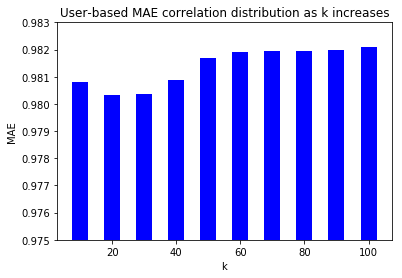

In [4]:
X=[10,20,30,40,50,60,70,80,90,100] 
Y=[0.9808051007612987,0.9803219656589165,0.980358184819963,0.9808850859069592,0.981706396075496,0.9819276803958288,0.9819343851470739,0.9819383158543232,0.9819977389412647,0.9820926475927453]
fig = plt.figure()
plt.bar(X,Y,5,color="blue")  
plt.xlabel("k")  
plt.ylabel("MAE") 
plt.ylim(0.975,0.983)
plt.title("User-based MAE correlation distribution as k increases")    
plt.show()  

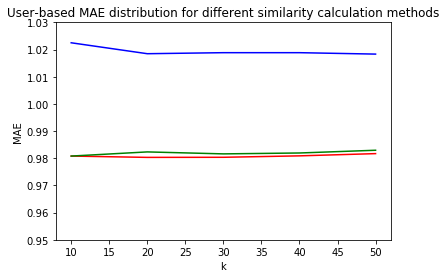

In [25]:
X=[10,20,30,40,50] 
Y1=[0.9808051007612987,0.9803219656589165,0.980358184819963,0.9808850859069592,0.981706396075496]#pearson
Y2=[0.9808051007612987,0.9823343870675297,0.9816122314103713,0.9819401987897299,0.9829476378128365]#cosine
Y3=[1.0224867901402408,1.0184658928954553,1.0188450949671404,1.0188450949671404,1.0183229676059802]#jaccard
pl.plot(X,Y1,color="red") 
pl.plot(X,Y2,color="green") 
pl.plot(X,Y3,color="blue") 
pl.xlabel("k")  
pl.ylabel("MAE") 
pl.ylim(0.95,1.03)
pl.title("User-based MAE distribution for different similarity calculation methods")    
pl.show()  


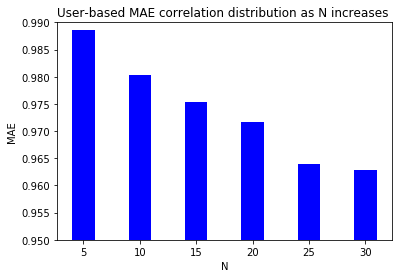

In [5]:
X=[5,10,15,20,25,30] 
Y=[0.9885250771478872,0.9802840616905629,0.9753177280323085,0.9715847819989459,0.9639916784869422,0.9628391367933024]
fig = plt.figure()
plt.bar(X,Y,2,color="blue")  
plt.xlabel("N")  
plt.ylabel("MAE") 
plt.ylim(0.95,0.99)
plt.title("User-based MAE correlation distribution as N increases ")    
plt.show()

In [45]:
print(MAE(10,ubase1,utest1,test_items,items,users)) #user-based,k=10,N=5,recommend for all users  colleration

0.9885250771478872


In [6]:
print(MAE(10,ubase1,utest1,test_items,items,users)) #user-based,k=10,N=10recommend for all users  colleration

0.9802840616905629


In [4]:
print(MAE(10,ubase1,utest1,test_items,items,users)) #user-based,k=10,N=15 recommend for all users  colleration

0.9753177280323085


In [6]:
print(MAE(10,ubase1,utest1,test_items,items,users)) #user-based,k=10,N=20 recommend for all users  colleration

0.9715847819989459


In [8]:
print(MAE(10,ubase1,utest1,test_items,items,users)) #user-based,k=10,N=25 recommend for all users  colleration

0.9639916784869422


In [10]:
print(MAE(10,ubase1,utest1,test_items,items,users)) #user-based,k=10,N=30 recommend for all users  colleration

0.9628391367933024


In [ ]:
#_____________________________________________Item-Based______________________________________________________

In [17]:
u=345#item based
predict_items(10,u,ubase1,items)

[[4.3139016116264948, 6],
 [4.3028090550308269, 120],
 [4.252082760160965, 49],
 [4.2298041980132961, 233],
 [4.223806624038553, 21],
 [4.2117315638013801, 78],
 [4.1963318969990357, 63],
 [4.1852059945123461, 236],
 [4.175326039329514, 180],
 [4.1683101924714183, 10]]

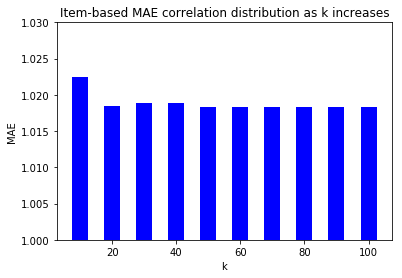

In [24]:
X=[10,20,30,40,50,60,70,80,90,100] 
Y=[1.0224867901402408,1.0184658928954553,1.0188450949671404,1.0188450949671404,1.0183229676059802,1.0183229676059802,1.0183229676059802,1.0183229676059802,1.0183229676059802,1.0183229676059802]
fig = plt.figure()
plt.bar(X,Y,5,color="blue")  
plt.xlabel("k")  
plt.ylabel("MAE") 
plt.ylim(1.0,1.03)
plt.title("Item-based MAE correlation distribution as k increases")    
plt.show()  

In [ ]:
#_____________________________________________User-Item-Based______________________________________________________

In [5]:
u=99
print('reccomend 10 movies for user 98:')
print('predicted_rating   movieId')
predict_hybrid(10,u,ubase1,items)  #k=10

reccomend 10 movies for user 98:
predicted_rating   movieId


[[5, 60],
 [5, 59],
 [4.9168058742211187, 120],
 [4.9143549174556211, 6],
 [4.9075526065995714, 545],
 [4.8931902183465974, 264],
 [4.877106928495504, 233],
 [4.8688698284149492, 407],
 [4.8582070270941262, 188],
 [4.8297529999662911, 267]]

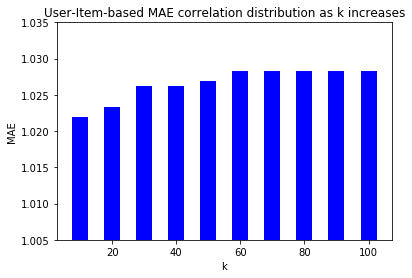

In [41]:
X=[10,20,30,40,50,60,70,80,90,100] 
Y=[1.021930184999806,1.0232778175478656,1.0262429389248472,1.0262442387289749,1.0269463256238523,1.0283229676059802,1.0283229676059802,1.0283229676059802,1.0283229676059802,1.0283229676059802]
fig = plt.figure()
plt.bar(X,Y,5,color="blue")  
plt.xlabel("k")  
plt.ylabel("MAE") 
plt.ylim(1.005,1.035)
plt.title("User-Item-based MAE correlation distribution as k increases")    
plt.show()  


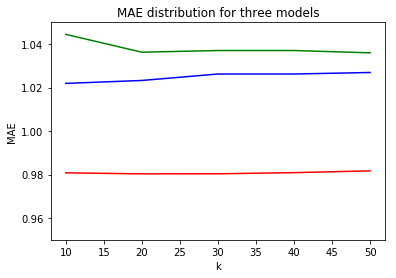

In [30]:
X=[10,20,30,40,50] 
Y1=[0.9808051007612987,0.9803219656589165,0.980358184819963,0.9808850859069592,0.981706396075496] #user
Y2=[1.0444792360112929,1.0362727749913372,1.0370453275386013,1.0370453275386013,1.0359816663538504]#item
Y3=[1.021930184999806,1.0232778175478656,1.0262429389248472,1.0262442387289749,1.0269463256238523]#user-item
pl.plot(X,Y1,color="red") 
pl.plot(X,Y2,color="green") 
pl.plot(X,Y3,color="blue") 
pl.xlabel("k")  
pl.ylabel("MAE") 
pl.ylim(0.95,1.05)
pl.title("MAE distribution for three models")    
pl.show()  